In [5]:
%load_ext autoreload

%autoreload 
import os
os.chdir("..\\..\\")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import networkx as nx
import numpy as np
from src.visualization.graph_plot_utils import plot_graph, plot_infection
import collections, functools, operator 
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# Start with 1% of population infected
def initial_infection(G, pct):
    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size)
    for node in G.nodes():
        if node in infected: G.nodes[node].update({'status' : 'infected', 'infection_day': 0, 'contacts_infected': 0})
        else: G.nodes[node].update({'status': 'susceptible', 'infection_day' : -1, 'contacts_infected': 0})
        
def spread_one_step(G, chance_to_infect = 0.3):
    newly_infected = []
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'infected':
            for contact in adjacencies[1].keys():
                if G.nodes[contact]['status'] == 'susceptible' and np.random.random() < chance_to_infect:
                        newly_infected.append(contact)
     
    for node in np.unique(newly_infected):
        G.nodes[node].update({'status' : 'infected'})
        
    return len(newly_infected)

def current_status(G):
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result

In [91]:
G = nx.relaxed_caveman_graph(25, 4, 0.25, seed=42)
initial_infection(G, .05)
plot_infection(G)


In [110]:
G = nx.relaxed_caveman_graph(250, 4, 0.25, seed=42)
#G = nx.scale_free_graph(1000)

initial_infection(G, .001)

pop = len(G.nodes)
i = current_status(G)['infected'] / pop
s = (pop - i) / pop
newly_infected = pop * .001

status = current_status(G)
data = [[s,i, newly_infected]]
while status['infected'] < 0.9*len(G.nodes):
    newly_infected = spread_one_step(G)
    status = current_status(G)
    i = status['infected'] / pop
    s = (pop -  status['infected']) / pop
    data.append([s, i, newly_infected])

time_series = pd.DataFrame(data, columns = ['susceptible', 'infected', 'newly_infected'])

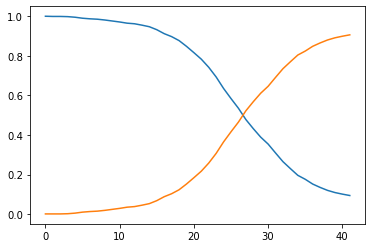

In [112]:
plt.plot(time_series.index, time_series['susceptible'])
plt.plot(time_series.index, time_series['infected'])


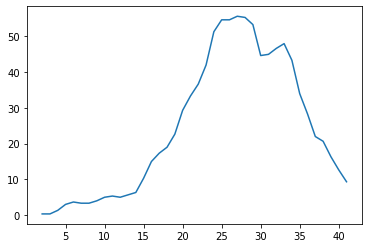

In [113]:
ni_rolling = time_series['newly_infected'].rolling(3).mean()[2:]
plt.plot(ni_rolling.index, ni_rolling.values)


In [148]:
def spread_one_step(G, chance_to_infect = 0.3):
    newly_infected = []
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'infected':
            for contact in adjacencies[1].keys():
                if G.nodes[contact]['status'] == 'susceptible' and np.random.random() < chance_to_infect:
                        newly_infected.append(contact)
     
    for node in np.unique(newly_infected):
        G.nodes[node].update({'status' : 'infected'})


# The time for a single person to recover is estimated to be 12 days
#The effective infection time window is estimated to bem around the 4 and the 6th day 
# Infection time window still not implemented
def spread_one_step_with_recover(G, day, infectious_window = [4,6], recover_time = 12, chance_to_infect = 0.5):
    newly_infected = []
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'infected':
            if day - G.nodes[node]['infection_day'] >= recover_time: 
                G.nodes[node]['status'] = 'recovered'
            else:
                for contact in adjacencies[1].keys():
                    if G.nodes[contact]['status'] == 'susceptible' and np.random.random() < chance_to_infect:
                            newly_infected.append(contact)
                            G.nodes[node]['contacts_infected'] += 1
     
    for node in np.unique(newly_infected):
        G.nodes[node].update({'status' : 'infected', 'infection_day': day})
        
    return len(newly_infected)

In [160]:
G = nx.relaxed_caveman_graph(250, 4, 0.25, seed=42)
initial_infection(G, .05)

pop = len(G.nodes)
i = current_status(G)['infected'] / pop
s = (pop - i) / pop
newly_infected = pop * .05
r = 0

status = current_status(G)
data = [[s,i, r, newly_infected]]
day = 0
while status['infected'] < 0.9*pop and status['recovered'] + status['susceptible'] < pop:
    day +=1
    newly_infected = spread_one_step_with_recover(G, day)
    status = current_status(G)
    i = status['infected'] / pop
    s = status['susceptible'] / pop
    r = status['recovered'] / pop
    data.append([s, i, r, newly_infected])
    
time_series = pd.DataFrame(data, columns = ['susceptible', 'infected', 'recovered', 'newly_infected'])

In [165]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is E6E0-67EF

 Directory of C:\Users\GuilhermeYambanisTho

04/26/2020  01:21 PM    <DIR>          .
04/26/2020  01:21 PM    <DIR>          ..
04/26/2020  05:13 AM               373 .bash_history
04/14/2020  09:30 PM    <DIR>          .cisco
04/15/2020  02:39 PM    <DIR>          .conda
04/22/2020  11:22 AM    <DIR>          .configprops
04/24/2020  01:40 PM    <DIR>          .cookiecutters
04/24/2020  01:41 PM    <DIR>          .cookiecutter_replay
04/22/2020  11:22 AM    <DIR>          .datastorage
04/16/2020  09:47 AM    <DIR>          .eclipse
04/17/2020  09:13 AM               171 .gitconfig
04/15/2020  02:38 PM    <DIR>          .ipython
04/15/2020  02:44 PM    <DIR>          .jupyter
04/15/2020  02:38 PM    <DIR>          .matplotlib
04/15/2020  02:38 PM    <DIR>          .spyder-py3
04/15/2020  02:35 PM    <DIR>          .vscode
04/14/2020  09:25 PM    <DIR>          3D Objects
04/14/2020  09:25 PM    <DIR>          Contacts
04

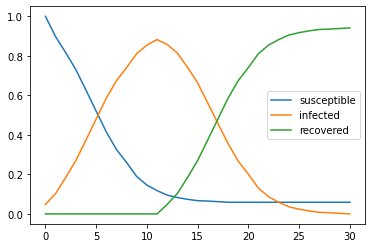

In [164]:
plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['recovered'], label = 'recovered')
plt.legend()
plt.savefig('spreadRelaxedCaveman.png', dpi=300)
plt.show()

# Disease evolution Model

## source : https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf



In [ ]:
G = nx.relaxed_caveman_graph(250, 4, 0.25, seed=42)
G = add_hub(G)
initial_infection(G, .05)

pop = len(G.nodes)
i = current_status(G)['infected'] / pop
s = (pop - i) / pop
newly_infected = pop * .05

status = current_status(G)
data = [[s,i, newly_infected]]
while status['infected'] < 0.9*len(G.nodes):
    newly_infected = spread_one_step(G)
    status = current_status(G)
    i = status['infected'] / pop
    s = (pop -  status['infected']) / pop
    data.append([s, i, newly_infected])
    
time_series = pd.DataFrame(data, columns = ['susceptible', 'infected', 'newly_infected'])